# Conversions between colour spaces
---
This notebook is part 1/5 of a tutorial based on the [```colourspace```](https://github.com/gillesferrand/colourspace) package.

In [1]:
from colourspace import convert

convertor = 'custom' (illuminant = 'D65')


The ```convert``` module performs conversions between colour spaces.

## From perceptual LCH to machine RGB

Our adopted perceptual colour space is LCH, the cylindrical parametrization of the CIE L\*a\*b\* colour space. Its 3 coordinates are 
L = lightness in [0,100], 
C = chroma >= 0, 
H = hue angle in [0, 360].<br>
When displayed on a digital screen, the colour model always is RGB, with R, G, B, the fraction of the Red, Green, Blue primaries, expressed in [0,1].<br>
So we need to be able to easily convert coordinates between LCH and RGB.

The function ```LCH2RGB()``` takes a tuple (L,C,H) and returns a tuple (R,G,B).

In [2]:
L =  50 # mid-grey
C = 100 # 
H = 310 # violet
RGB = convert.LCH2RGB(L,C,H)
print(RGB)

(0.57827564085034333, 0.29738641634601931, 0.98819126452258133)


This conversion actually involves 3 steps:<br>
\- from cylindrical LCH to Cartesian Lab<br>
\- from CIE Lab to CIE XYZ<br>
(this step requires to set an illuminant, assumed to be the standard D65)<br>
\- from XYZ to sRGB

In [3]:
print("LCH = ",L,C,H)
print("Lab = ",convert.LCH2Lab((L,C,H)))
print("XYZ = ",convert.Lab2XYZ(convert.LCH2Lab((L,C,H)))," for illuminant = ",convert.illuminant)
print("RGB = ",convert.XYZ2RGB(convert.Lab2XYZ(convert.LCH2Lab((L,C,H)))))

('LCH = ', 50, 100, 310)
('Lab = ', (50, 64.278760968653927, -76.604444311897808))
('XYZ = ', (32.256265448524921, 18.418651851244416, 93.940775908218868), ' for illuminant = ', 'D65')
('RGB = ', (0.57827564085034333, 0.29738641634601931, 0.98819126452258133))


### Using other convertors

The default convertor is 'custom', that is the formulas coded inside the module itself (taken from [www.easyrgb.com](http://www.easyrgb.com/en/math.php)).<br>
It is possible to wire the ```LCH2RGB```/```RGB2LCH``` conversion functions to the functions provided by other colour packages, this has been done for [```colorspacious```](https://pypi.python.org/pypi/colorspacious/) and for [```colour```](https://github.com/colour-science/colour) by [colour-science.org](http://colour-science.org).

In [4]:
convert.set_convertor('colorspacious')

convertor = 'colorspacious' (illuminant = 'D65')


In [5]:
print(np.array(convert.LCH2RGB(L,C,H)))
print(np.array(convert.LCH2RGB(L,C,H))-RGB)

[ 0.57827564  0.29738642  0.98819126]
[  0.00000000e+00   5.55111512e-17   0.00000000e+00]


In [6]:
convert.set_convertor('colourscience')

convertor = 'colourscience' (illuminant = 'D65')


In [7]:
print(np.array(convert.LCH2RGB(L,C,H)))
print(np.array(convert.LCH2RGB(L,C,H))-RGB)

[ 0.57817373  0.2974125   0.98828389]
[ -1.01910259e-04   2.60822285e-05   9.26254709e-05]


In [8]:
convert.set_convertor('custom')

convertor = 'custom' (illuminant = 'D65')


### Vectorization

The conversion functions can be applied on a tuple of NumPy arrays of any (matching) shape, and will return a tuple of NumPy arrays of the same shape. You can stack these to get an array of tuples (for colour arrays, Matplotlib is expecting the RGBA channels to be the last index).

In [9]:
nx = 11
L = np.linspace(0,100,nx)
H = 310*np.ones(nx)
C = (1-abs((L[:]-50)/50.)) * 100 # boost C at medium L, up to arbitrary value
print("L = ",L)
print("C = ",C)
print("H = ",H)
RGB = convert.LCH2RGB(L,C,H)
print("(R,G,B) = ",RGB)
RGB = np.stack(RGB,axis=-1)
print("RGB = ",RGB)

('L = ', array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
         90.,  100.]))
('C = ', array([   0.,   20.,   40.,   60.,   80.,  100.,   80.,   60.,   40.,
         20.,    0.]))
('H = ', array([ 310.,  310.,  310.,  310.,  310.,  310.,  310.,  310.,  310.,
        310.,  310.]))
('(R,G,B) = ', (array([ 0.        ,  0.13317109,  0.23695082,  0.34596836,  0.45988744,
        0.57827564,  0.68470904,  0.77685365,  0.85883743,  0.93280553,
        1.00000107]), array([ 0.        ,  0.08601416,  0.13801624,  0.19042131,  0.2435057 ,
        0.29738642,  0.444991  ,  0.58451027,  0.72229917,  0.86050645,
        1.00003343]), array([ 0.        ,  0.18918312,  0.36723061,  0.561767  ,  0.76945424,
        0.98819126,  0.99514548,  1.0000753 ,  1.00271025,  1.0027644 ,
        0.99992724])))
('RGB = ', array([[ 0.        ,  0.        ,  0.        ],
       [ 0.13317109,  0.08601416,  0.18918312],
       [ 0.23695082,  0.13801624,  0.36723061],
       [ 0.34596836,  0.

## Gamut control

In [10]:
L =  50 # mid-grey
C = 100 # 
H = 360 # red
RGB = convert.LCH2RGB(L,C,H)
print(RGB)

(1.0076014140783198, -0.83868814525600499, 0.48281361264041672)


We got R&gt;1 and G&lt;0, so this triplet is not a valid colour: it lies outside of the sRGB gamut.<br>
When this happens, we may either discard the colour entirely (by flagging it as invalid) or alter it so that it is representable (by restricting the values to the valid range). In this package I call these modes resp. "crop" and "clip".

In [11]:
convert.crop3(RGB)

array([        nan,         nan,  0.48281361])

In [12]:
convert.clip3(RGB)

array([ 1.        ,  0.        ,  0.48281361])

Note that the ```crop3()``` and ```clip3()``` functions work on tuples, and return a NumPy array already stacked as expected by Matplotlib.

## Example of image making

In [13]:
%matplotlib inline
import pylab as plt

Using a ramp of L and random H:

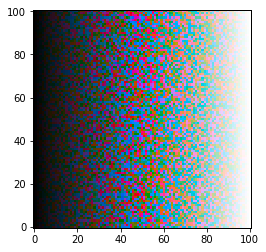

In [14]:
nx = 101
ny = 101
L = np.tile(np.linspace(0,100,nx),(ny,1))
H = 360*np.random.rand(nx,ny)
C = (1-abs((L[:,:]-50)/50.)) * 100 # boost C at medium L, up to arbitrary value
RGB = convert.clip3(convert.LCH2RGB(L,C,H))
plt.imshow(RGB,origin='lower')

Here we have made an educated guess for C. To be able to meaningfully design in LCH space, we need to know the gamut boundaries. This is explained in the next notebook.

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img align="left" alt="Creative Commons License" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br>
<br>Gilles Ferrand
<br>2019-12-24